Student name: David Schenck<br>
Student pace: Flex<br>
Scheduled project review date/time:<br>
Instructor Name: Morgan Jones<br>
Blog post URL:

# Project Description

The World Health Organization (WHO) estimates that 2 million children below the age of 5 die from pneumonia every year, making it the leading cause of child mortality worldwide. The vast majority of cases and deaths are in developing countries, particularly in Africa and Southeast Asia.

Timely diagnosis of pneumonia is key for improving health outcomes for patients. It is also important to determine whether the pneumonia is caused by a bacterial or a viral infection since the treatment plans are very different depending on the cause.

One effective method of diagnosing pneumonia is by taking chest X-rays. A medical expert can identify the telltale signs of pneumonia by observing the X-rays, but some facilities in developing countries lack such an expert. This slows down the process of diagnosing the disease, leading to delays in medical intervention.

A potential solution is to create a computer model that can interpret the chest X-rays. Such a model could be made available to medical facilities across the world, helping to shorten the time it takes to diagnose pediatric pneumonia so that life-saving treatment can be provided faster.

In this project, I train a convolutional neural network (CNN) to diagnose pneumonia using a labeled set of chest X-rays.

### Data
The data used in this project was obtained from https://data.mendeley.com/datasets/rscbjbr9sj/3.

The data contains 5856 images of chest X-rays taken for children 5 years of age or younger. The images were examined by 2 medical experts to determine whether the patient has pneumonia and, if so, whether it is bacterial or viral pneumonia. A third expert validated their classifications.

The data is split into train and test directories, and each of those is split into "NORMAL" and "PNEUMONIA" directories. The images corresponding to a patient with bacterial pneumonia all start with "BACTERIA" and those with viral pneumonia start with "VIRUS". Patients without pneumonia all of images starting with "NORMAL".

Below is a breakdown of how many images there are in each directory:

train - NORMAL: 1349<br>
train - PNEUMONIA: 3883 (BACTERIA: 2538, VIRUS: 1345)<br>
test - NORMAL: 234<br>
test - PNEUMONIA: 390 (BACTERIA: 242, VIRUS: 148)

In addition to indicating whether the patient has pneumonia, the filename also includes a unique 6-digit code for each patient and a 4-digit code counting the number of images for that patient since some patients have multiple images. For example, a patient with multiple images will have their first image will end with 0001, second with 0002, and so on.

The images have a variety of dimensions and aspect ratios. They are cropped and resized to a standard size before they are input to the CNN.

Note: The zip file provided at https://data.mendeley.com/datasets/rscbjbr9sj/3 contains data of both chest X-ray images for diagnosing pneumonia and optimal coherence tomography (OCT) images for diagnosing eye conditions. I only use the chest X-ray images.

In [25]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.utils import to_categorical
import os
import datetime
import matplotlib.pyplot as plt
from keras import regularizers, initializers
%matplotlib inline
plt.style.use('ggplot')

### Data Exploration

First, I just want to see how many images are in each directory

In [26]:
# Count the number of images in each directory
# Main directory
maindir = 'C:/Users/david/Documents/Flatiron/phase_4/PneumoniaData/ZhangLabData/CellData/chest_xray/'
# Subdirectories in main directory
subdirs = ['train/NORMAL/','train/PNEUMONIA/','test/NORMAL/','test/PNEUMONIA/']

sum_normal = 0
sum_bacteria = 0
sum_virus = 0
for directory in subdirs:
    files = os.listdir(maindir+directory)
    # Only keep images
    files = [x for x in files if 'jpeg' in x]

    if 'PNEUMONIA' in directory:
        print(directory, '\t BACTERIA:',sum([1 if 'BACTERIA' in x else 0 for x in files]),
              'VIRUS:', sum([1 if 'VIRUS' in x else 0 for x in files]))
        sum_bacteria += sum([1 if 'BACTERIA' in x else 0 for x in files])
        sum_virus += sum([1 if 'VIRUS' in x else 0 for x in files])
    else:
        print(directory, '\t \t NORMAL:', len(files))
        sum_normal += len(files)

train/NORMAL/ 	 	 NORMAL: 1349
train/PNEUMONIA/ 	 BACTERIA: 2538 VIRUS: 1345
test/NORMAL/ 	 	 NORMAL: 234
test/PNEUMONIA/ 	 BACTERIA: 242 VIRUS: 148


Text(0.5, 1.0, 'Number of X-rays per Category')

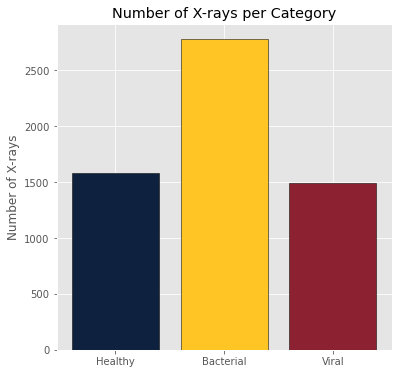

In [27]:
fig, ax = plt.subplots(figsize=(6,6))

ax.bar([0,1,2],[sum_normal, sum_bacteria,sum_virus], color=['#0e2240','#fec524','#8b2131'], edgecolor='black')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Healthy','Bacterial','Viral'])
ax.set_ylabel('Number of X-rays')
ax.set_title('Number of X-rays per Category')

**Normal vs. Pneumonia**

Below, I want to see if there is a visible difference in X-rays of healthy patients vs. patients with either bacterial or viral pneumonia.

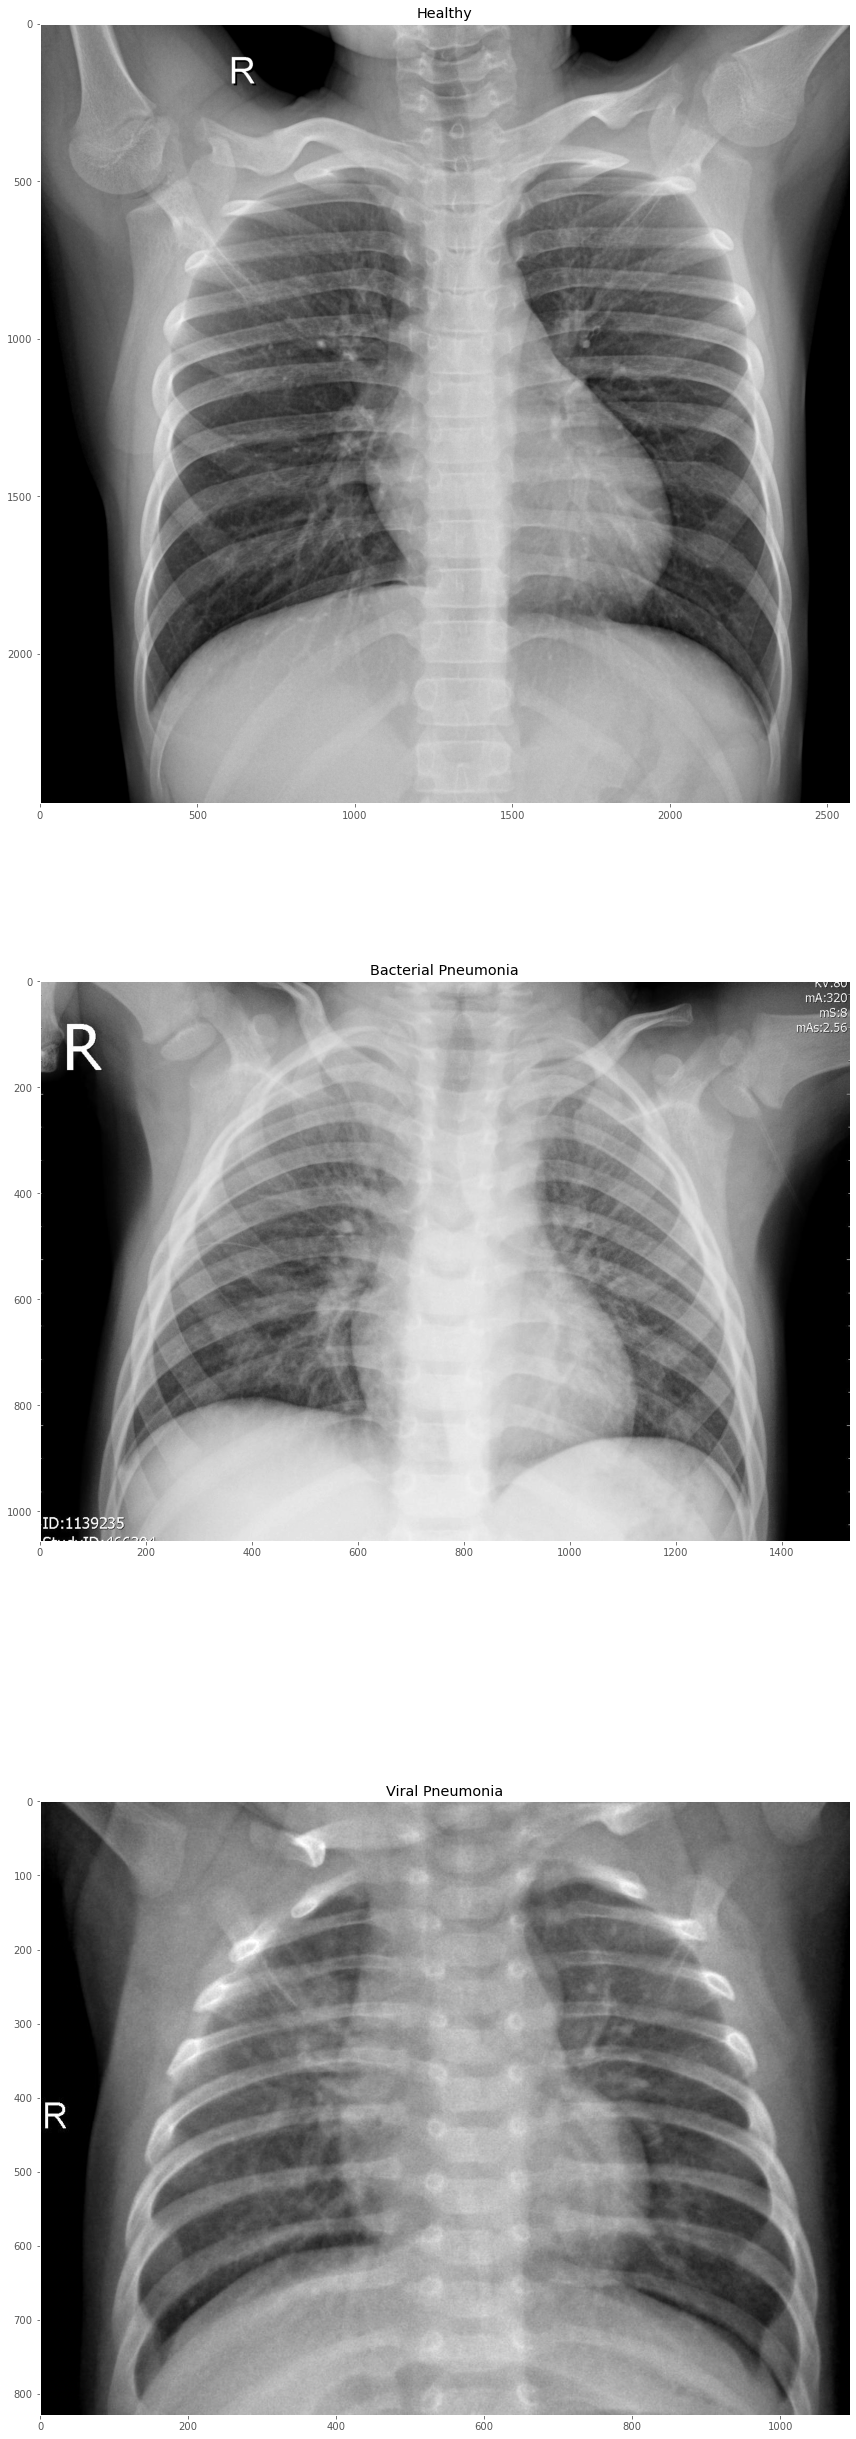

In [28]:
# Get one NORMAL image
files_normal = [maindir+subdirs[0]+x for x in os.listdir(maindir+subdirs[0]) if 'jpeg' in x]
image_normal = img_to_array(load_img(files_normal[0], color_mode='grayscale'))
# Get one BACTERIA image
files_bacteria = [maindir+subdirs[1]+x for x in os.listdir(maindir+subdirs[1]) if 'BACTERIA' in x]
image_bacteria = img_to_array(load_img(files_bacteria[6], color_mode='grayscale'))
# Get one VIRUS image
files_virus = [maindir+subdirs[1]+x for x in os.listdir(maindir+subdirs[1]) if 'VIRUS' in x]
image_virus = img_to_array(load_img(files_virus[1], color_mode='grayscale'))

fig, ax = plt.subplots(nrows=3, figsize=(12,36))

ax[0].imshow(image_normal, cmap='gray')
ax[0].set_title('Healthy')
ax[0].grid(False)
ax[1].imshow(image_bacteria, cmap='gray')
ax[1].set_title('Bacterial Pneumonia')
ax[1].grid(False)
ax[2].imshow(image_virus, cmap='gray')
ax[2].set_title('Viral Pneumonia')
ax[2].grid(False)
fig.tight_layout()

The three images above do a good job demonstrating why diagnosing pneumonia through X-rays isn't something that an untrained person could easily do. Pneumonia is a lung disease, so one would expect to see differences in the lungs. When I look at the images, I notice filamentary structures, but it is not at all obvious to me that there is a difference. I could maybe convince myself that the filaments are thicker, maybe indicating they are inflamed, in the two pneumonia images, but I would not be confident making any diagnoses based on that. The CNN is going to need to pick up on more subtle differences in the images to be successful.

**Aspect Ratio**

The images have different dimensions and aspect ratios. I will crop and resize the images to a common size. Below, I determine what the average aspect ratio is. I will use this for the final aspect ratio.

In [29]:
# Get a list of all files
names = [os.path.join(maindir+subdirs[0], name) for name in os.listdir(maindir+subdirs[0])] + \
        [os.path.join(maindir+subdirs[1], name) for name in os.listdir(maindir+subdirs[1])] + \
        [os.path.join(maindir+subdirs[2], name) for name in os.listdir(maindir+subdirs[2])] + \
        [os.path.join(maindir+subdirs[3], name) for name in os.listdir(maindir+subdirs[3])]

img_dims = []
for img_path in names:
    if 'jpeg' in img_path:
        img = load_img(img_path, color_mode='grayscale')
        img_dims.append([img.height,img.width])
img_dims = np.array(img_dims)

0.7147827266780963


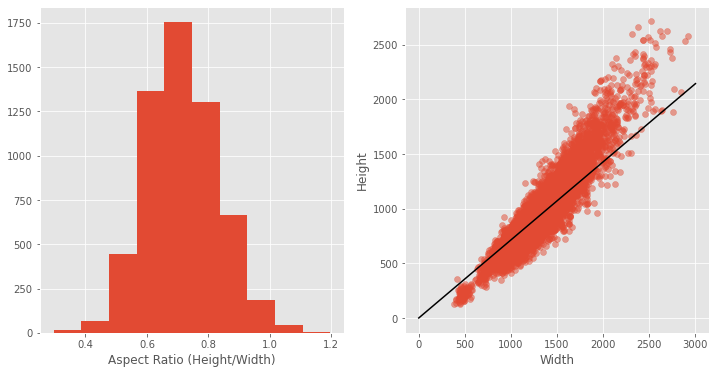

In [30]:
# Plot a histogram of aspect ratio and scatter plot of height and width
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

aspect_ratios = img_dims[:,0]/img_dims[:,1]
mean_aspect = np.mean(aspect_ratios)
print(mean_aspect)
ax[0].hist(aspect_ratios)
ax[0].set_xlabel('Aspect Ratio (Height/Width)')
ax[1].scatter(img_dims[:,1],img_dims[:,0],alpha=0.5)
ax[1].set_ylabel('Height')
ax[1].set_xlabel('Width')
ax[1].plot([0,3000],[0,3000*mean_aspect],color='black');

The mean aspect ratio is 0.715. I will use this aspect ratio when I create the tensors for use in the CNN models.

**Cropping and Resizing**

Below, I create a function that will read in an image, crop it, and resize it. The function also gives an option for rescaling, which is useful because CNN models tend to converge better if the values are between 0 and 1.

I could just resize without cropping, but this would result in stretching the image either vertically or horizontally if the aspect ratio is not equal to the aspect ratio of the desired dimensions. By cropping first, I avoid stretching the images.

The way I crop the images is by checking whether the image is too tall or too wide (compared to the average aspect ratio). If it is too tall, I will crop equal amounts from the top and bottom of the image to achieve the desired aspect ratio. If it is too wide, I crop equal amounts from the left and right. I tested this on a few images and the parts of images that get cut out should not be important for diagnosing pneumonia. The lungs are what matters and they don't get cropped out using the function below.

I am curious whether the model will do better on higher resolution images (even if the images are all downsampled to the same dimensions). Because of this, I added an option to return the original dimensions of the image.

In [31]:
def crop_resize_image(filepath, dims=None, rescale=None, return_orig_dims=False):
    """
    Reads in an image, crops it, and resizes it so that the final array has dimensions dims.
    Input:
    filepath: Full directory path to image.
    dims: Desired dimensions of image as tuple. Default is None, in which case no cropping or resizing is done.
    rescale: Number by which to multiply the image. Default is to not rescale.
    return_orig_dims: Tells function whether or not to return the original dimensions of the image. Default is False.
    """
    img = load_img(filepath, color_mode='grayscale')
    if dims == None:
        img_array = img_to_array(img)
    # Crop and resize if dims is specified
    else:
        desired_aspect = dims[0]/dims[1]
        if img.height/img.width > desired_aspect:
            desired_height = img.width * desired_aspect
            cut = np.round((img.height - desired_height)/2,0)
            img_crop = img.crop((0,cut,img.width,img.height-cut))
        else:
            desired_width = img.height / desired_aspect
            cut = np.round((img.width - desired_width)/2,0)
            img_crop = img.crop((cut,0,img.width-cut,img.height))
        img_resize = img_crop.resize((dims[1],dims[0]))
        img_array = img_to_array(img_resize)
        
    # Rescale the image if rescale is defined
    if rescale != None:
        img_array *= rescale
    if return_orig_dims:
        return img_array[:,:,0], [img.height, img.width]
    else:
        return img_array[:,:,0]

In [32]:
# Try out the function above
directory = maindir + subdirs[0]
files = [x for x in os.listdir(directory) if 'jpeg' in x]
# Desired width of images
width = 180
# Dimensions use mean aspect ratio.
dimensions = (int(np.round(mean_aspect*width,0)), width)
img_array = crop_resize_image(directory+files[6], dimensions, 1/255)
img_array.shape

(129, 180)

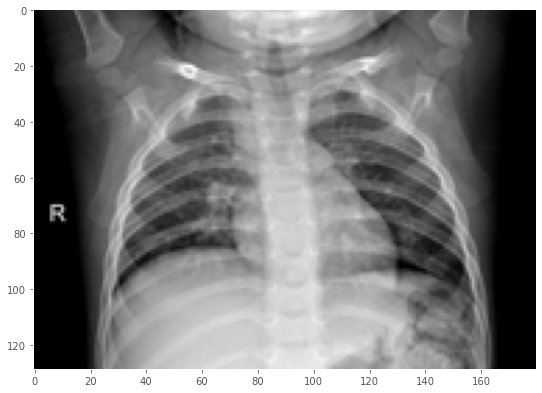

In [33]:
# Display an image after it has been cropped and resized
fig, ax = plt.subplots(figsize=(9,9))
ax.imshow(img_array, cmap='gray')
ax.grid(False)

The image above was cropped and resized to the desired dimensions. The image is not stretched or shrunk even though the original aspect ratio of the image might not have been the same as the final aspect ratio.

**Functions for Preparing Data**

The function below is used to get samples of images. The function allows the user to specify how many images to collect and whether you want one or two samples (useful for creating train and validation splits)

In [34]:
def get_image_filenames(rootdir, subdir, size='all', size2=0):
    """
    This function collects filenames of images.
    Input:
    rootdir: The directory that contains all of the data.
    subdir: Indicates whether to collect images from 'train' or 'test'.
    size: Number of images to collect. Default is collect all the images.
    size2: If indicated, it is the number of images to collect for a second sample.
        This is useful for creating a validation sample which won't overlap with the training sample.2
        
    Output:
    One list of files and one list of labels (if size2=0) or two lists of files and two lists of labels if size2>0.
    """
    # Get image names from NORMAL
    directory = rootdir + subdir + '/NORMAL/'
    files_normal = [directory+x for x in os.listdir(directory) if 'jpeg' in x]
    # Get image names from PNEUMONIA
    directory = rootdir + subdir + '/PNEUMONIA/'
    files_pneum = [directory+x for x in os.listdir(directory) if 'jpeg' in x]
    files_bacteria = [x for x in files_pneum if 'BACTERIA' in x]
    files_virus = [x for x in files_pneum if 'VIRUS' in x]

    # Check to make sure we did not ask for more files than exist in the directories
    if size != 'all':
        check = (len(files_normal) >= size+size2) * (len(files_bacteria) >= size+size2) * (len(files_virus) >= size+size2)
        if check == False:
            raise Exception('Asked for more images than are actually present')
    
    if size == 'all':
        filenames = np.append(files_normal, np.append(files_bacteria, files_virus))

        return filenames

    else:
        sample_normal = np.random.choice(files_normal, size+size2, replace=False)
        sample_bacteria = np.random.choice(files_bacteria, size+size2, replace=False)
        sample_virus = np.random.choice(files_virus, size+size2, replace=False)
            
        if size2 == 0:
            filenames = np.append(sample_normal, np.append(sample_bacteria, sample_virus))

            return filenames
        else:
            filenames1 = np.append(sample_normal[0:size], np.append(sample_bacteria[0:size],sample_virus[0:size]))
            filenames2 = np.append(sample_normal[size:], np.append(sample_bacteria[size:],sample_virus[size:]))

            return filenames1, filenames2

In [35]:
def create_tensors(filenames, dims, OHE=True):
    """
    Function for turning a list of filenames into tensors that can be input to a CNN model.
    Inputs:
    filenames: List of filenames.
    dims: The desired dimensions of the output.
    OHE: Indicates whether the class labels should be one-hot encoded. Default is True.
    """
    x = np.zeros((len(filenames), dims[0], dims[1]))
    y = np.zeros(len(filenames))
    # Save the original dimensions (will use after fitting model)
    dims_orig = np.zeros((len(filenames),2))

    # Loop over files
    for n, file in enumerate(filenames):
        # Add image to tensor and dimensions to dims_orig
        x[n], dims_orig[n] = crop_resize_image(file, dims, 1/255, return_orig_dims=True)
        
        # Determine the class of the image
        if 'NORMAL' in file:
            y[n] = 0
        elif 'BACTERIA' in file:
            y[n] = 1
        elif 'VIRUS' in file:
            y[n] = 2
        else:
            raise Exception(f"Cannot determine class for {file}")

    # One-hot encode the classes if OHE is True
    if OHE:
        y = to_categorical(y, 3)

    # Reshape x into a tensor
    x = x.reshape(-1, dims[0], dims[1], 1)
    return x, y, dims_orig

Below, I use the functions I have written to create train, validation, and test samples.

In [36]:
# Set random seed
np.random.seed(42)
# Size of train dataset
train_size = 500
# Size of validation dataset
val_size = 100

# Desired width of images
width = 180
# Dimensions use mean aspect ratio.
dimensions = (int(np.round(mean_aspect*width,0)), width)

# Get list of images for train and validation
train_list, val_list = get_image_filenames(maindir,
                                           subdir='train',
                                           size=train_size,
                                           size2=val_size)

# Get list of images for test
test_list = get_image_filenames(maindir,
                                subdir='test',
                                size='all')

# Create tensors for train, validation, and test
x_train, y_train, dims_train = create_tensors(train_list, dimensions, OHE=True)
x_val, y_val, dims_val = create_tensors(val_list, dimensions, OHE=True)
x_test, y_test, dims_test = create_tensors(test_list, dimensions, OHE=True)

**Image Size by Class**

Before I actually start creating a model, I want to see how the image dimensions are split between the classes.

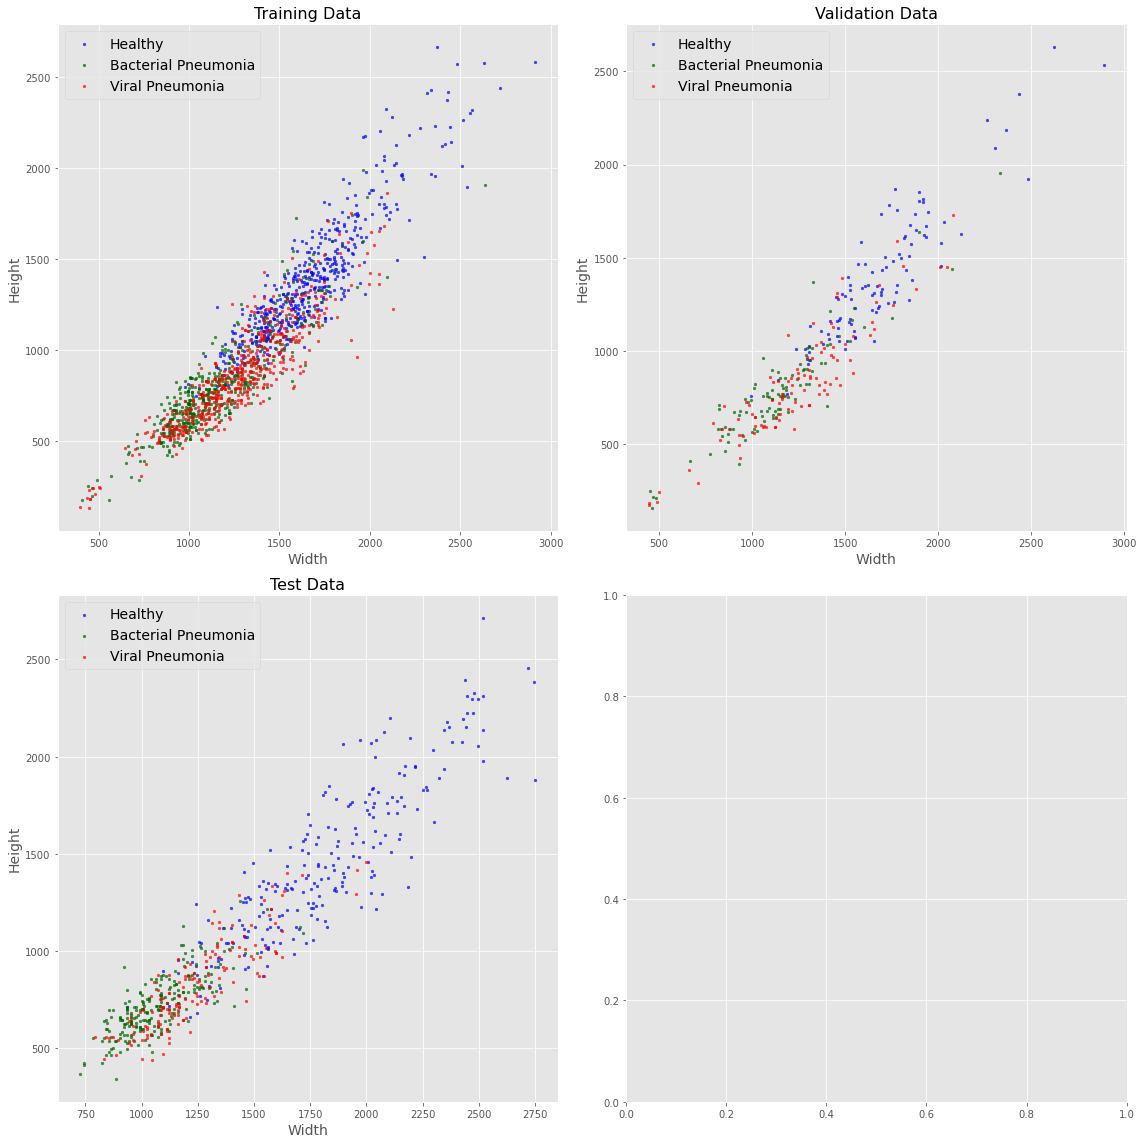

In [121]:
# Make plot of image dimensions colored based on class
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,16))

color_list = ['blue','darkgreen','red']
label_list = ['Healthy','Bacterial Pneumonia','Viral Pneumonia']

# Training Data
for n in range(3):
    ax[0,0].scatter([a[1] for a,c in zip(dims_train,np.argmax(y_train, axis=-1)) if c==n],
                    [a[0] for a,c in zip(dims_train,np.argmax(y_train, axis=-1)) if c==n],
                    color=color_list[n], alpha=0.7, s=7, label=label_list[n])

ax[0,0].set_xlabel('Width', fontsize=14)
ax[0,0].set_ylabel('Height', fontsize=14)
ax[0,0].set_title('Training Data', fontsize=16)
ax[0,0].legend(fontsize=14)

# Validation Data
for n in range(3):
    ax[0,1].scatter([a[1] for a,c in zip(dims_val,np.argmax(y_val, axis=-1)) if c==n],
                    [a[0] for a,c in zip(dims_val,np.argmax(y_val, axis=-1)) if c==n],
                    color=color_list[n], alpha=0.7, s=7, label=label_list[n])

ax[0,1].set_xlabel('Width', fontsize=14)
ax[0,1].set_ylabel('Height', fontsize=14)
ax[0,1].set_title('Validation Data', fontsize=16)
ax[0,1].legend(fontsize=14)

# Test Data
for n in range(3):
    ax[1,0].scatter([a[1] for a,c in zip(dims_test,np.argmax(y_test, axis=-1)) if c==n],
                    [a[0] for a,c in zip(dims_test,np.argmax(y_test, axis=-1)) if c==n],
                    color=color_list[n], alpha=0.7, s=7, label=label_list[n])

ax[1,0].set_xlabel('Width', fontsize=14)
ax[1,0].set_ylabel('Height', fontsize=14)
ax[1,0].set_title('Test Data', fontsize=16)
ax[1,0].legend(fontsize=14)

fig.tight_layout()

In all three splits of the data (training, validation, test), the images for healthy patients tended to be larger than those for patients with pneumonia. Usually, a systematic difference like this would be a cause for concern, but I am going to downsample all the images to a common size and shape anyway. After fitting the model, I will look to see whether the performance was correlated with the original image size.

In [37]:
# Import modules needed for creating a CNN model
from keras import models
from keras import layers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

### Building a Convolutional Neural Network

I am going to iteratively create a convolutional neural network. In order to evaluate the models, I need to look at some metrics. It will be helpful to have a function I can call that will display the metrics I care about.

The function below will create and print a classification report, a confusion matrix, and ROC curves. Since there are three classes, three ROC curves are created by considering one class vs. the others. Classification reports and confusion matrices will be created for train, validation, and test datasets. ROC curves will only be created for the test dataset.

In [38]:
def display_metrics(model, train_data=None, val_data=None, test_data=None):
    """
    Function for displaying classification reports, confusion matrices, and ROC curves.
    Classification reports and confusion matrices are created for train, validation, and test data.
    ROC curves are only created for the test data.
    
    Inputs:
    model: The fitted model.
    train_data, val_data, test_data: (x,y) tuple containing different types of data.
    Default is None, in which case no classification report or confusion matrix will be displayed.
    
    """
    # Classification reports
    
    count = 0
    
    if train_data != None:
        print("Classification Report: Train")
        print(classification_report(np.argmax(train_data[1], axis=-1),
                                    np.argmax(model.predict(train_data[0]), axis=-1),
                                    labels=[0,1,2],
                                    target_names=['NORMAL','BACTERIA','VIRUS'],
                                    digits=3))
        count += 1
    if val_data != None:
        print("Classification Report: Validation")
        print(classification_report(np.argmax(val_data[1], axis=-1),
                                    np.argmax(model.predict(val_data[0]), axis=-1),
                                    labels=[0,1,2],
                                    target_names=['NORMAL','BACTERIA','VIRUS'],
                                    digits=3))
        count += 1
    if test_data != None:
        print("Classification Report: Test")
        print(classification_report(np.argmax(test_data[1], axis=-1),
                                    np.argmax(model.predict(test_data[0]), axis=-1),
                                    labels=[0,1,2],
                                    target_names=['NORMAL','BACTERIA','VIRUS'],
                                    digits=3))
        count += 1
        
    # Confusion Matrices
    fig, ax = plt.subplots(ncols=count, figsize=(count*5,4))
    n = 0
    if train_data != None:
        # Get confusion matrix
        cf = confusion_matrix(np.argmax(train_data[1], axis=-1), np.argmax(model.predict(train_data[0]), axis=-1))
        # Calculate binary accuracy (healthy vs. pneumonia)
        acc_train = (np.sum(cf)-cf[0,1]-cf[0,2]-cf[1,0]-cf[2,0])/np.sum(cf)
        # Display confusion matrix
        ConfusionMatrixDisplay(cf, display_labels=['NORMAL','BACTERIA','VIRUS']).plot(ax=ax[n])
        ax[n].set_title('Train')
        ax[n].grid(False)
        n += 1
    if val_data != None:
        # Get confusion matrix
        cf = confusion_matrix(np.argmax(val_data[1], axis=-1), np.argmax(model.predict(val_data[0]), axis=-1))
        # Calculate binary accuracy (healthy vs. pneumonia)
        acc_val = (np.sum(cf)-cf[0,1]-cf[0,2]-cf[1,0]-cf[2,0])/np.sum(cf)
        # Display confusion matrix
        ConfusionMatrixDisplay(cf, display_labels=['NORMAL','BACTERIA','VIRUS']).plot(ax=ax[n])
        ax[n].set_title('Validation')
        ax[n].grid(False)
        n += 1
    if test_data != None:
        # Get confusion matrix
        cf = confusion_matrix(np.argmax(test_data[1], axis=-1), np.argmax(model.predict(test_data[0]), axis=-1))
        # Calculate binary accuracy (healthy vs. pneumonia)
        acc_test = (np.sum(cf)-cf[0,1]-cf[0,2]-cf[1,0]-cf[2,0])/np.sum(cf)
        # Display confusion matrix
        ConfusionMatrixDisplay(cf, display_labels=['NORMAL','BACTERIA','VIRUS']).plot(ax=ax[n])
        ax[n].set_title('Test')
        ax[n].grid(False)

    fig.tight_layout()
    
    # Print binary accuracy (healthy vs. pneumonia)
    print('Binary Accuracy')
    print('Train:', round(acc_train,3))
    print('Validation:', round(acc_val,3))
    print('Test:', round(acc_test,3))
    
    # ROC curves (only test data)
    if test_data != None:
        fig2, ax2 = plt.subplots(figsize=(6,6))
        
        ax2.plot([0,1],[0,1])
        
        for i, case in enumerate(['NORMAL vs. Rest','BACTERIA vs. Rest','VIRUS vs. Rest']):
            fpr, tpr, thresh = roc_curve(test_data[1][:,i], model.predict(test_data[0])[:,i])
            ax2.plot(fpr, tpr, label=f"{case}: {round(auc(fpr, tpr),3)}")
        ax2.set_title('ROC Curve: Test Data')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.legend()

I also created a function for displaying the loss and accuracy as a function of epoch.

In [39]:
def plot_history(history):
    """
    Function to plot the loss and accuracy vs epoch for a model.
    Input is the history of a model.
    """
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epoch = range(len(acc))
    
    fig, ax = plt.subplots(ncols=2, figsize=(15,7))

    ax[0].plot(epoch, acc, label='Training')
    ax[0].plot(epoch, val_acc, label='Validation')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()

    ax[1].plot(epoch, loss, label='Training')
    ax[1].plot(epoch, val_loss, label='Validation')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

**Iteratively Making a Model**

The way I am going to create the model is by running a model, evaluating its performance, than changing one aspect of that model for the next iteration, that way I can understand what difference that one change made. As a result, I may end up trying quite a few models. I do not want the notebook to have to rerun every single model I try when I run the notebook, so instead I will summarize the results of each model in the table in the cell below. Only the final model will be included in the final notebook, but the performance of each model will be present in the table.

### Evaluation

The table below summarizes the performance of each model.<br>
The Description column says which model was changed and how to create a new model. For example, if the table says Model 4 is "3 + L2 regularization", it means that Model 4 is exactly the same as Model 3 except it uses L2 regularization.

Model 1 is described in detail below:<br>
**Input**: The input is a tensor with 1500 images that have been downsampled to 129x180. There are 500 of each class. The correct class labels are input as one-hot encode arrays.<br>
**Layers**: The model contains 4 Conv2D layers. Each layer uses a 3x3 kernel. The number of filters in each Conv2D layer are 32, 32, 64, and 128. After each Conv2D layer is a MaxPooling2D layer to downsample the images using a 2x2 kernel. This reduces the sizes of the images. After the 4 Conv2D-MaxPooling2D layers, there is a Flatten layer, a Dense layer with 128 nodes, then finally the output Dense layer with three nodes (one per class). The activation function is 'relu' for every layer except the output layer which uses 'softmax'.<br>
**Regularization**: The first model uses no regularization or Dropout layers.<br>
**optimizer**: SGD.<br>
**epochs**: 80.<br>
**batch_size**: 30.<br>
**loss function**: categorical_crossentropy. This will not change for any of the models.


|Version |Description |Train Accuracy |Binary Train Accuracy |Test Accuracy |Binary Test Accuracy |Recall (healthy) |Recall (bacterial) |Recall (viral) |AUC (healthy) |AUC (bacterial) |AUC (viral) |time (s) |
|-----|------------------------|--------|--------|-------|-------|-------|-------|--------|-------|-------|--------|-------|
|1    |Baseline                |89.1%   |97.7%   |73.4%  |87.7%  |75.6%  |62.8%  |87.2%   |0.945  |0.935  |0.896   |1257   |
|2    |1 + RMSprop optimizer   |100%    |100%    |78.5%  |92.9%  |85.0%  |74.0%  |75.7%   |0.97   |0.924  |0.888   |1217   |
|3    |2 + Dropout layers      |99.9%   |100%    |83.7%  |93.6%  |89.3%  |83.9%  |74.3%   |0.971  |0.934  |0.917   |1372   |
|4    |3 + L2 regularization   |82.7%   |96.1%   |81.7%  |90.9%  |82.1%  |84.7%  |76.4%   |0.957  |0.938  |0.906   |1420   |
|5    |4 + remove a layer      |92.5%   |97.9%   |82.5%  |91.8%  |85.5%  |80.6%  |81.1%   |0.957  |0.926  |0.913   |1332   |
|6    |5 input is 172x240      |94.5%   |98.5%   |81.2%  |93.1%  |87.6%  |72.7%  |85.1%   |0.962  |0.927  |0.902   |2376   |
|7    |5 with 2400 input images|84.1%   |95.5%   |81.7%  |89.6%  |86.8%  |86.0%  |66.9%   |0.953  |0.918  |0.914   |2014   |
|8    |5 + L2 constant=0.008   |84.0%   |96.1%   |79.0%  |89.4%  |76.9%  |81.0%  |79.1%   |0.956  |0.931  |0.906   |1300   |

Descriptions:<br>
**Model 1**: The first model achieved decent accuracy on the test data (73.4%), but there is definitely room for improvement. The model did overfit a bit as the accuracy on the training data was 89.1%. The model appeared to start overfitting a little before epoch 50. The model performed the worst on the bacterial pneumonia images (62.8% recall). This is one metric I really want to improve.<br>
Before I start addressing the overfitting, I want to test out other optimizers.

**Model 2**: This model is the same as Model 1, but uses the RMSprop optimizer instead of SGD.<br>
This model overfit much more than Model 1; the accuracy on training data was 100%. Despite the overfitting, the performance on the test data did improve. The accuracy was about 5% higher on both overall accuracy and binary accuracy. The recall improved by around 10% for both healthy and bacterial pneumonia images, but the performance on viral images got worse.
If I can address the overfitting in this model without degrading the performance too much, that would be ideal.

**Model 3**: This model is Model 2, but with Dropout layers after each Conv2D-MaxPooling2D layer. There is also a Dropout layer after the first Dense layer. The Dropout layers are set to drop 20% each time.<br>
The presence of the Dropout layers barely reduced the overfitting. The overall accuracy was nearly 100% instead of actually being 100%. The good news is that the overall performance on the test data did improve. The accuracy went up another 5% and the binary accuracy got a little higher.<br>
Next, I will iterate on this model using regularization to try to reduce the overfitting further.

**Model 4**: This model is Model 3, but it uses L2 regularization (with a value of 0.005) on the Conv2D layers and the first Dense layer. I am still keeping the Dropout layers.<br>
The overfitting has been eliminated. Throughout the entire 80 epochs, the accuracy of the test data did not deviate much from the accuracy on the train data. The overall performance on the test data is a little worse (overall accuracy down 2% from Model 3).

**Model 5**: This model reduces the depth of the network by removing the Conv2D layer that has 128 filters and reduces the number of nodes in the first dense layer from 128 to 64. Counterintuitively, this model actually has more trainable parameters than the last because it also gets rid of one MaxPooling2D layer, which means it does not reduce the image size as much.<br>
This model outperformed Model 4 in both overall accuracy and binary accuracy (though by a small amount). It is overfitting a little, but it is not nearly as severe as Model 2 or 3.

**Model 6**: This model is the same as Model 5, except that the input images are 172x240 instead of 129x180. The increase in resolution unsurprisingly makes the model take longer. If I am going to use higher resolution images in my final model, they better increase the performance significantly.<br>
The model did not seriously improve over Model 5. While the binary accuracy did increase, the overall accuracy actually decreased by 1% and the performance on bacterial pneumonia cases got worse. This sort of performance does not justify almost doubling the training time.

**Model 7**: This model is Model 5, but the input data contains 2400 images (800 of each class) instead of 1500 images. Like Model 6, I want to see significant improvement because adding more data increases the fit time.<br>
This model did better on bacterial pneumonia, but signficantly worse on viral pneumonia. Overall, there was not a big enough improvement to necessitate using 2400 images. It seems like 1500 is a solid amount to train the model.

**Model 8**: This model is Model 5, but the L2 regularization constant has been increased to 0.008 from 0.005. This was done to try to reduce the overfitting just a bit more.<br>
This model performed worse than Model 5. The overfitting was not even improved.

In [48]:
# Create the model
regularizer_all = regularizers.l2(0.005)
initializer_all = initializers.glorot_normal(seed=123)

model = models.Sequential()
model.add(layers.Conv2D(32,
                        (3, 3),
                        activation='relu',
                        kernel_regularizer=regularizer_all,
                        kernel_initializer=initializer_all,
                        input_shape=(dimensions[0], dimensions[1], 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32,
                        (3, 3),
                        activation='relu',
                        kernel_regularizer=regularizer_all,
                        kernel_initializer=initializer_all))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64,
                        (3, 3),
                        activation='relu',
                        kernel_regularizer=regularizer_all,
                        kernel_initializer=initializer_all))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(64,
                       activation='relu',
                       kernel_regularizer=regularizer_all,
                       kernel_initializer=initializer_all))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3,
                       activation='softmax',
                       kernel_regularizer=regularizer_all,
                       kernel_initializer=initializer_all))

model.compile(loss='categorical_crossentropy',
              optimizer="rmsprop",
              metrics=['acc'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 127, 178, 32)      320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 89, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 63, 89, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 61, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 43, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 30, 43, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 41, 64)       

In [49]:
start = datetime.datetime.now()
history = model.fit(x_train,
                    y_train,
                    epochs=80,
                    batch_size=30,
                    validation_data=(x_val, y_val))
end = datetime.datetime.now()
print(end-start)

Epoch 1/80
50/50 [==============================] - 18s 352ms/step - loss: 1.6608 - acc: 0.3807 - val_loss: 1.3510 - val_acc: 0.3967
Epoch 2/80
50/50 [==============================] - 17s 337ms/step - loss: 1.1751 - acc: 0.5247 - val_loss: 1.0741 - val_acc: 0.5933
Epoch 3/80
50/50 [==============================] - 16s 329ms/step - loss: 1.0064 - acc: 0.5980 - val_loss: 0.9376 - val_acc: 0.7000
Epoch 4/80
50/50 [==============================] - 16s 329ms/step - loss: 0.9246 - acc: 0.6500 - val_loss: 0.9200 - val_acc: 0.6700
Epoch 5/80
50/50 [==============================] - 16s 329ms/step - loss: 0.8805 - acc: 0.6580 - val_loss: 0.8871 - val_acc: 0.6467
Epoch 6/80
50/50 [==============================] - 16s 328ms/step - loss: 0.8403 - acc: 0.6960 - val_loss: 0.8445 - val_acc: 0.6667
Epoch 7/80
50/50 [==============================] - 17s 336ms/step - loss: 0.8397 - acc: 0.7027 - val_loss: 0.8211 - val_acc: 0.7133
Epoch 8/80
50/50 [==============================] - 16s 328ms/step - 

50/50 [==============================] - 16s 325ms/step - loss: 0.5774 - acc: 0.8140 - val_loss: 0.7134 - val_acc: 0.7700
Epoch 63/80
50/50 [==============================] - 16s 321ms/step - loss: 0.5683 - acc: 0.8160 - val_loss: 0.8827 - val_acc: 0.7100
Epoch 64/80
50/50 [==============================] - 16s 322ms/step - loss: 0.5664 - acc: 0.8267 - val_loss: 0.7292 - val_acc: 0.7567
Epoch 65/80
50/50 [==============================] - 16s 322ms/step - loss: 0.5592 - acc: 0.8220 - val_loss: 0.7221 - val_acc: 0.7600
Epoch 66/80
50/50 [==============================] - 16s 322ms/step - loss: 0.5738 - acc: 0.8207 - val_loss: 0.7275 - val_acc: 0.7567
Epoch 67/80
50/50 [==============================] - 16s 322ms/step - loss: 0.5912 - acc: 0.8167 - val_loss: 0.7716 - val_acc: 0.7467
Epoch 68/80
50/50 [==============================] - 16s 321ms/step - loss: 0.5553 - acc: 0.8273 - val_loss: 0.7525 - val_acc: 0.7667
Epoch 69/80
50/50 [==============================] - 16s 322ms/step - loss

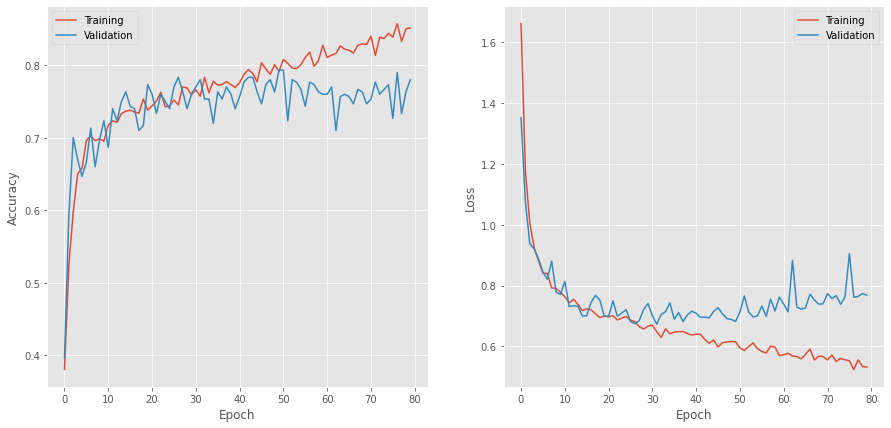

In [50]:
# Plot loss and accuracy vs epoch
plot_history(history)

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      0.957     0.980     0.968       500
    BACTERIA      0.917     0.908     0.913       500
       VIRUS      0.901     0.888     0.894       500

    accuracy                          0.925      1500
   macro avg      0.925     0.925     0.925      1500
weighted avg      0.925     0.925     0.925      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.872     0.950     0.909       100
    BACTERIA      0.720     0.720     0.720       100
       VIRUS      0.736     0.670     0.702       100

    accuracy                          0.780       300
   macro avg      0.776     0.780     0.777       300
weighted avg      0.776     0.780     0.777       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.922     0.855     0.887       234
    BACTERIA      0.852     0.806     

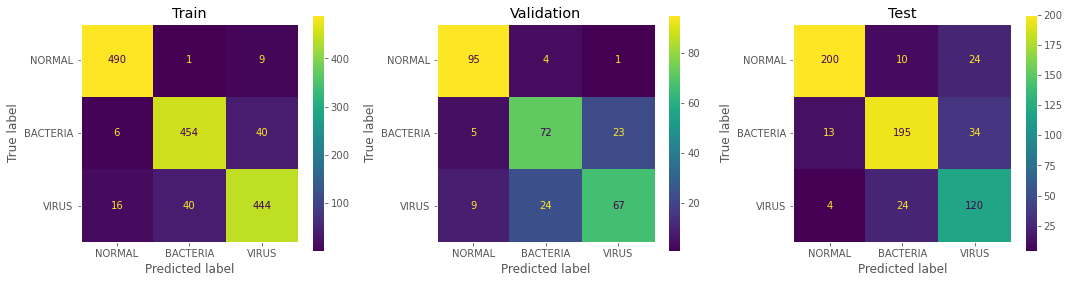

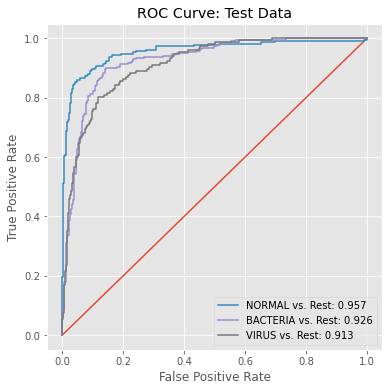

In [51]:
# Display classification reports, confusion matrices, and ROC curves.
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

The best model was saved below as an H5 file.

In [53]:
# Save model if desired by uncommenting
#model.save('model5.h5')

# Load model from H5 by uncommenting
#model_load = models.load_model('model5.h5')

### Results

**Best Model**

The best model in terms of both performance and not overfitting was Model 5. Model 5 differed from the baseline model in the following ways:<br>
1. Used RMSprop as optimizer instead of SGD.
2. Used one less Conv2D-MaxPooling2D layer.
3. Had Dropout layers.
4. Had L2 regularization.

This model achieved 82.5% accuracy when considering all three classes and 91.8% accuracy when considering just two classes (healthy vs. pneumonia). This was also the only model that achieved a recall above 80% for all three classes. The other models tended to have one class that lagged behind the others in recall, but this model had a better balance.

**Overall Performance of the Models**

While Model 5 was deemed the best model, the performance of the models was quite promising across the board. Other than Model 1, the accuracy for the test data was always above 78% and the binary accuracy was above 89%. This shows that getting good performance out of the CNN does not require a specific architecture or very tight fine-tuning of parameters. This isn't to say there aren't gains that can be made, but the model performs decently given a variety of CNN designs.

**False Negatives**

In the context of diagnosing pneumonia, false negatives are the worst case scenario. A false negative would mean that a patient has pneumonia, but the model says that they do not. Part of the reason pneumonia is one of the leading causes of death among young children worldwide is because many cases are left undiagnosed (or diagnosed too late), so when a model fails to detect pneumonia, it could be fatal. The test data contains 390 images of patients with either bacterial or viral pneumonia. Out of those 390, Model 5 returned 17 predictions (4.4%) saying there was no pneumonia at all. For another 58 (14.9%), Model 5 identified the wrong type of pneumonia. This could still be a major problem because providing the wrong treatment could be as bad as providing no treatment at all. This leaves 81% of sick patients whose pneumonia was correctly diagnosed by Model 5. For a medical facility lacking an expert able to interpret chest X-rays by eye, this would be a useful tool for diagnosing pediatric pneumonia.

### Digging Deeper Into Model Performance

Below, I look a little deeper into the performance of Model 5 which performed the best.

First, I check to see if the original image dimensions have any affect on the accuracy of the predictions.

In [54]:
# Make array that indicates whether prediction is correct
correct = np.argmax(y_test, axis=-1)==np.argmax(model.predict(x_test), axis=-1)

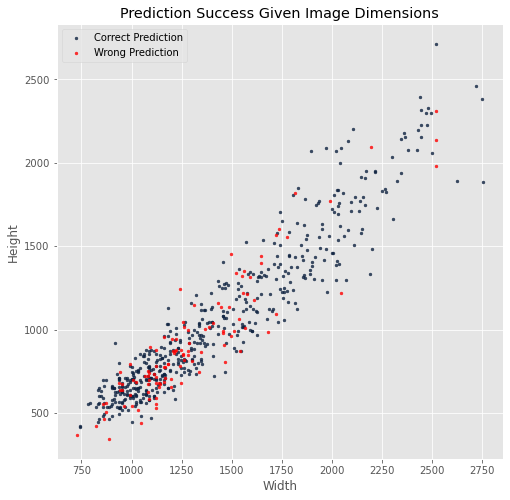

In [61]:
# Make plot of image dimensions colored by whether it is correct
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter([a[1] for a, c in zip(dims_test,correct) if c],
           [a[0] for a, c in zip(dims_test,correct) if c],
           color='#0e2240',
           alpha=0.8,
           s=8,
           label='Correct Prediction')

ax.scatter([a[1] for a, c in zip(dims_test,correct) if not c],
           [a[0] for a, c in zip(dims_test,correct) if not c],
           color='red',
           alpha=0.8,
           s=8,
           label='Wrong Prediction')

ax.set_xlabel('Width')
ax.set_ylabel('Height')
ax.set_title('Prediction Success Given Image Dimensions')
ax.legend()

Just based on looking at the graph above, it does seem like there could be a larger fraction of wrong predictions (red points) for smaller images (lower left) and fewer for larger images (upper right). I will check to see if this trend is really present by dividing the data into 4 parts (each containing 156 images) based on the square root of the number of pixels. I will look at the accuracy within each group.

In [63]:
# Calculate the square root of the number of pixels for each image
sqrtpix = np.sqrt(dims_test[:,0]*dims_test[:,1])
sqrtpix

array([2143.41689832, 1783.47077352, 1341.83680081, 1912.84291043,
       1758.70861714, 1564.07352768, 1070.98085884, 1425.03333294,
       1614.2986093 , 1766.08720057, 1698.09893705, 1334.59207251,
       1262.85470265, 2231.84744102, 1244.        ,  896.47532035,
       1540.49342744, 1233.21530967, 1601.47744286, 1449.52130029,
       1706.77590796, 1620.67208281,  897.09754208, 1484.97070678,
       1351.84318617, 1513.46060405, 1375.53625906, 1054.33391295,
       1445.234929  , 1850.09405166, 2160.44069578, 1602.79755428,
       2150.95327704, 2294.95533726, 2018.89078456, 1682.65504486,
       1543.09494199, 1147.29595136, 1546.79798293, 2379.08469795,
       2026.68448457, 1699.2645468 , 1892.6341432 , 1164.3504627 ,
       1305.57113939, 1256.90572439, 2393.91227909, 1384.03684922,
       2381.44766896, 1372.1107827 , 1484.15969491, 1362.22611926,
       1100.19998182, 1734.51549431, 1921.47131126, 1289.23543234,
       1464.39338977, 1656.84760917, 1804.99972299, 1472.09850

Smallest 156 images: 0.846
2nd Smallest 156 images: 0.763
2nd Largest 156 images: 0.782
Largest 156 images: 0.91


Text(3, 0.7, 'Larger\nImages\nPerformed\nBetter')

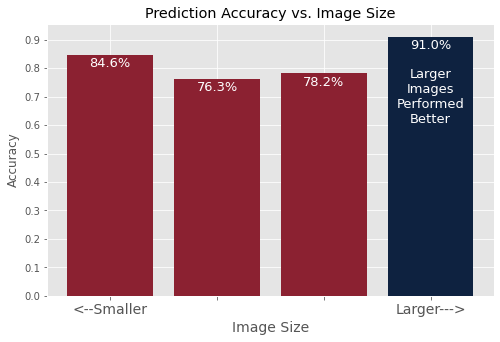

In [109]:
# Create array to sort by sqrt of number of pixels
pix_argsort = np.argsort(sqrtpix)

group_accuracy = []

for n in range(4):
    correct_group = correct[pix_argsort[n*156:(n+1)*156]]
    group_accuracy.append(sum(correct_group)/len(correct_group))
    
print('Smallest 156 images:', round(group_accuracy[0],3))
print('2nd Smallest 156 images:', round(group_accuracy[1],3))
print('2nd Largest 156 images:', round(group_accuracy[2],3))
print('Largest 156 images:', round(group_accuracy[3],3))

fig, ax = plt.subplots(figsize=(8,5))

ax.bar(range(4), group_accuracy, color=['#8b2131','#8b2131','#8b2131','#0e2240'])
ax.set_xlabel('Image Size',fontsize=14)
ax.set_xticks(range(4))
ax.set_xticklabels(['<--Smaller','','','Larger--->'], fontsize=14)
ax.set_ylabel('Accuracy')
ax.set_yticks(np.arange(10)/10)
ax.set_title('Prediction Accuracy vs. Image Size')
for n in range(4):
    ax.text(n, group_accuracy[n]-0.03, f"{round(100*group_accuracy[n],1)}%",
            horizontalalignment='center',
            verticalalignment='center',
            color='white',
            fontsize=13)
ax.text(3, 0.7, 'Larger\nImages\nPerformed\nBetter',
        horizontalalignment='center',
        verticalalignment='center',
        color='white',
        fontsize=13)

The largest 156 images did have the highest overall accuracy (91%). Strangely, the smallest 156 images were second at 84.6%. The middle 312 images averaged out to around 77%. I don't think the performance was better on larger images because those images were larger. Instead, we saw earlier that the images for healthy patients tended to be larger than those who had pneumonia. The model performed better on the images for healthy patients, which is why it seems like larger images were preferred.

While I believe that the model would perform better on healthy X-rays regardless of resolution, it is possible that the higher resolution is the reason why the model did better with healthy images. I would like to collect another sample of X-rays that has a similar distribution of image sizes for each class.

### Recommendations

1. **Distributing the model to those who need it**: Having a working model only helps if those who need it are able to use it. Just like we can't assume there will be a doctor who can diagnose pneumonia from a chest X-ray, we can't assume that there will be someone who can run Python code either. I would want to work with a software engineer to productionize the model in a way that is easy to use. Ideally, I would want the model integrated into whatever software is used to display the X-ray images so that the technician only has to click one or two buttons to get a diagnosis.

2. **Closely monitor success of treatment**: While the model correctly determines whether a child has some sort of pneumonia over 90% of the time, the success rate of identifying the correct type of pneumonia is closer to 80%. I would recommend that once a treatment plan is started, the patient is monitored very closely to make sure the correct treatment has been provided. If the model says a patient has bacterial pneumonia, but is not responding to antibiotics, the doctors should keep in mind that it might still be viral pneumonia despite what the model said.

2. **Collect more uniform data**: The chest X-rays of healthy patients were typically of a higher resolution than those of patients with pneumonia. While all of the data is downsampled to a common image size before fitting the model, it is still possible that this systematic difference in the images could affect the performance of the model. I am not a doctor, so I don't know why this difference in image resolution is present in the data, but if it is possible to collect chest X-rays that do not have this class-dependent difference in resolution, then it can be checked whether this affects the model.